# Exercise: Supervised learning by using different cost functions

In this exercise, we'll take a deeper look at how cost functions can change:

* How well models appear to have fit data
* The kinds of relationships a model represents

## Loading the data

Let's start by loading the data. To make this exercise simpler, we'll use only a few datapoints this time.

In [1]:
import pandas
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/microsoft_custom_linear_regressor.py
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv
from datetime import datetime

# Load a file that contains our weather data
dataset = pandas.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Convert the dates into numbers so we can use them in our models
# We make a year column that can contain fractions. For example,
# 1948.5 is halfway through the year 1948
dataset["year"] = [(d.year + d.timetuple().tm_yday / 365.25) for d in dataset.date]


# For the sake of this exercise, let's look at February 1 for the following years:
desired_dates = [
    datetime(1950,2,1),
    datetime(1960,2,1),
    datetime(1970,2,1),
    datetime(1980,2,1),
    datetime(1990,2,1),
    datetime(2000,2,1),
    datetime(2010,2,1),
    datetime(2017,2,1),
]

dataset = dataset[dataset.date.isin(desired_dates)].copy()

# Print the dataset
dataset


--2025-03-14 08:10:35--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/microsoft_custom_linear_regressor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2167 (2.1K) [text/plain]
Saving to: ‘microsoft_custom_linear_regressor.py’

microsoft_custom_li 100%[===================>]   2.12K  --.-KB/s    in 0s      

2025-03-14 08:10:35 (37.1 MB/s) - ‘microsoft_custom_linear_regressor.py’ saved [2167/2167]

--2025-03-14 08:10:37--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com 

,date,amount_of_precipitation,max_temperature,min_temperature,rain,year
762,1950-02-01,0.00,27,1,False,1950.087611
4414,1960-02-01,0.15,52,44,True,1960.087611
8067,1970-02-01,0.00,50,42,False,1970.087611
11719,1980-02-01,0.37,54,36,True,1980.087611
15372,1990-02-01,0.08,45,37,True,1990.087611
19024,2000-02-01,1.34,49,41,True,2000.087611
22677,2010-02-01,0.08,49,40,True,2010.087611
25234,2017-02-01,0.00,43,29,False,2017.087611


## Comparing two cost functions

Let's compare two common cost functions: the _sum of squared differences_ (SSD) and the _sum of absolute differences_ (SAD). They both calculate the difference between each predicted value and the expected value. The distinction is simply: 

* SSD squares that difference and sums the result.
* SAD converts differences into absolute differences and then sums them.

To see these cost functions in action, we need to first implement them:

In [2]:
import numpy

def sum_of_square_differences(estimate, actual):
    # Note that with NumPy, to square each value we use **
    return numpy.sum((estimate - actual)**2)

def sum_of_absolute_differences(estimate, actual):
    return numpy.sum(numpy.abs(estimate - actual))

They're very similar. How do they behave? Let's test with some fake model estimates.

Let's say that the correct answers are `1` and `3`, but the model estimates `2` and `2`:

In [3]:
actual_label = numpy.array([1, 3])
model_estimate = numpy.array([2, 2])

print("SSD:", sum_of_square_differences(model_estimate, actual_label))
print("SAD:", sum_of_absolute_differences(model_estimate, actual_label))

SSD: 2
SAD: 2


We have an error of `1` for each estimate, and both methods have returned the same error. 

What happens if we distribute these errors differently? Let's pretend that we estimated the first value perfectly, but were off by `2` for the second value: 

In [4]:
actual_label = numpy.array([1, 3])
model_estimate = numpy.array([1, 1])

print("SSD:", sum_of_square_differences(model_estimate, actual_label))
print("SAD:", sum_of_absolute_differences(model_estimate, actual_label))

SSD: 4
SAD: 2


SAD has calculated the same cost as before, because the average error is still the same (`1 + 1 = 0 + 2`). According to SAD, the first and second set of estimates were equally good. 

By contrast, SSD has given a higher (worse) cost for the second set of estimates ( $1^2 + 1^2 < 0^2 + 2^2 $ ). When we use SSD, we encourage models to be both accurate and consistent in their accuracy.


## Differences in action

Let's compare how our two cost functions affect model fitting.

First, fit a model by using the SSD cost function:

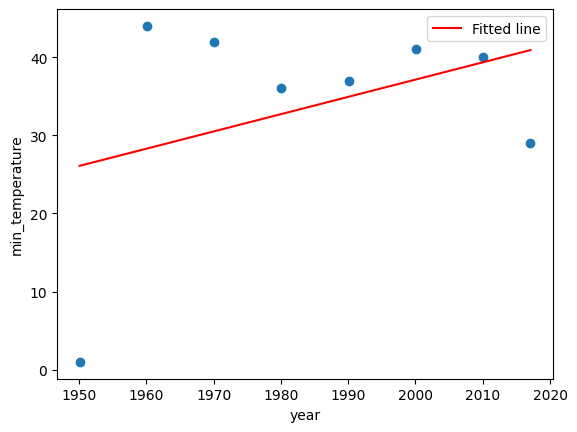

In [5]:
from microsoft_custom_linear_regressor import MicrosoftCustomLinearRegressor
import matplotlib.pyplot as plt

# Create and fit the model
# We use a custom object that we've hidden from this notebook, because
# you don't need to understand its details. This fits a linear model
# by using a provided cost function

# Fit a model by using sum of square differences
model = MicrosoftCustomLinearRegressor().fit(X = dataset.year, 
                                             y = dataset.min_temperature, 
                                             cost_function = sum_of_square_differences)

# Graph the model
plt.scatter(dataset["year"], dataset["min_temperature"])
plt.plot(dataset["year"], model.predict(dataset["year"]), 'r', label='Fitted line')

                                                 
# add labels and legend
plt.xlabel("year")
plt.ylabel("min_temperature")
plt.legend()

Our SSD method normally does well, but here it did a poor job. The line is a far distance from the values for many years. Why? Notice that the datapoint at the lower left doesn't seem to follow the trend of the other datapoints. 1950 was a very cold winter in Seattle, and this datapoint is strongly influencing our final model (the red line). What happens if we change the cost function?

### Sum of absolute differences

Let's repeat what we've just done, but using SAD.

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


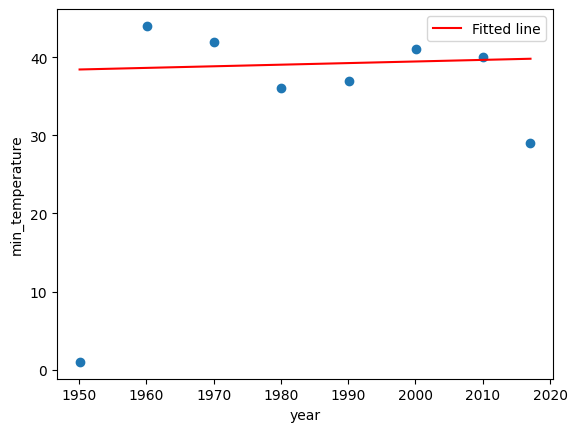

In [6]:
# Fit a model with SAD
# Fit a model by using sum of absolute differences
model = MicrosoftCustomLinearRegressor().fit(X = dataset.year, 
                                             y = dataset.min_temperature, 
                                             cost_function = sum_of_absolute_differences)

# Graph the model
plt.scatter(dataset["year"], dataset["min_temperature"])
plt.plot(dataset["year"], model.predict(dataset["year"]), 'r', label='Fitted line')

                                                 
# add labels and legend
plt.xlabel("year")
plt.ylabel("min_temperature")
plt.legend()


It's clear that this line passes through the majority of points much better than before, at the expense of almost ignoring the measurement taken in 1950. 

In our farming scenario, we're interested in how average temperatures are changing over time. We don't have much interest in 1950 specifically, so for us, this is a better result. In other situations, of course, we might consider this result worse.


## Summary

In this exercise, you learned about how changing the cost function that's used during fitting can result in different final results. 

You also learned how this behavior happens because these cost functions describe the "best" way to fit a model; although from a data analyst's point of view, there can be drawbacks no matter which cost function is chosen.